We import the necessary modules

In [9]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numba import jit

Definition of the constants and the initial fields

In [25]:
#############
# Constants #
#############

nb_points = 42

R = 8.314  # Ideal gas constant in J/(mol* K)

M_N2 = 0.02802  # kg/mol

M_air = 0.02895  # kg/mol

M_CH4 = 0.016042  # kg/mol

dt = 1e-6

final_time = 1

nb_timesteps = int(final_time / dt)

Lx = 2e-3

Ly = 2e-3

L_slot = 0.5e-3

L_coflow = 0.5e-3

U_slot = 1.0

T_slot = 300

U_coflow = 0.2

T_coflow = 300

rho = 1.1614 # Fluid density

dx = Lx / (nb_points - 1)

dy = Ly / (nb_points - 1)

nu = 15e-6

tolerance_sor = 1e-7 # Tolerance for the convergence of the SOR algorithm

tolerance_sys = 1e-4 # Tolerance for the convergence of the whole system

max_iter = 10000  # Maximum number of iterations for achieving convergence

omega = 1.5  # Parameter for the Successive Overrelaxation Method (SOR), it has to be between 1 and 2


##################
# Initial fields #
##################

x,y = np.linspace(Lx, 0, nb_points), np.linspace(Ly, 0, nb_points)
X,Y = np.meshgrid(x,y,indexing='xy')

# Velocity fields
v = np.zeros((nb_points, nb_points))
u = np.zeros((nb_points, nb_points))

# Pressure field
P = np.ones((nb_points, nb_points))

# Species field (nitrogen)
Y_n2 = np.zeros((nb_points, nb_points))

Function to apply boundary conditions to the fields

In [11]:
#@jit(fastmath=True, nopython=True)
def boundary_conditions(u, v, Y_n2):
    # Boundary conditions for the velocity field
    u[:, 1] = 0
    u[1, :] = 0
    u[-2, :] = 0
    u[:, -2] = u[:, -3] # du/dx = 0 at the right free limit

    v[1, :] = 0 # For the top non-slipping wall (some of these values are modified just after)
    v[-2, :] = 0 # For the bottom non-slipping wall
    v[1, 1 : int(L_slot / Lx * nb_points) + 1] = -U_slot # Speed at the top of the "flow" region (Methane)
    v[-2, 1 : int(L_slot / Lx * nb_points) + 1] = U_slot  # Speed at the bottom of the "flow" region (Air)
    v[1, int(L_slot / Lx * nb_points) + 1 : int((L_slot + L_coflow) / Lx * nb_points)] = -U_coflow  # Speed at the top of the "coflow" region (Nitrogen)
    v[-2, int(L_slot / Lx * nb_points) + 1 : int((L_slot + L_coflow) / Lx * nb_points)] = U_coflow # Speed at the bottom of the "coflow" region (Nitrogen)
    v[:, 1] = v[:, 2] # dv/dx = 0 at the left wall
    v[:, -2] = v[:, -3] # dv/dx = 0 at the right free limit

    Y_n2[-2, 1 : int(L_slot / Lx * nb_points) + 1] = 0.767 # Initial condition for the nitrogen in air (bottom slot)
    Y_n2[1, int(L_slot / Lx * nb_points) + 1 : int((L_slot + L_coflow) / Lx * nb_points)] = 1
    Y_n2[-2, int(L_slot / Lx * nb_points) + 1 : int((L_slot + L_coflow) / Lx * nb_points)] = 1

    return u, v, Y_n2

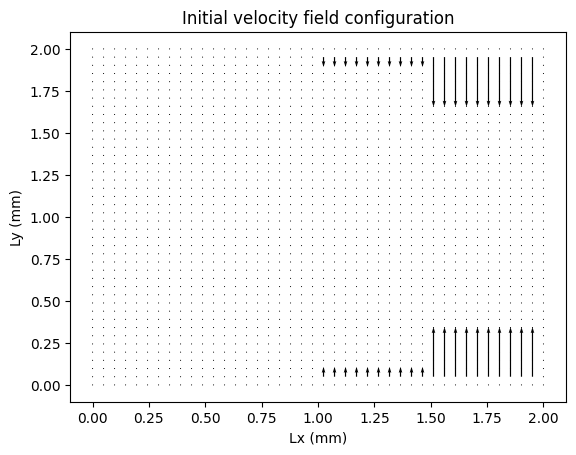

In [29]:
u, v, Y_n2 = boundary_conditions(u, v, Y_n2)

plt.quiver(X*1e3,Y*1e3,u,v,scale=10)
plt.title('Initial velocity field configuration')
plt.xlabel('Lx (mm)')
plt.ylabel('Ly (mm)')

plt.show()


In [12]:
#################################################
# Derivatives and second derivatives definition #
#################################################

# Attention: the sense of the derivatives is inversed!!

#@jit(fastmath=True, nopython=True)
def derivative_x_upwind(vel: np.array, a:np.array, dx=dx) -> np.array:
    dvel_dx = np.zeros_like(vel)

    # For interior points, choose upwind direction based on the sign of u
    for i in range(1, vel.shape[1] - 2): # Skip the boundaries
        dvel_dx[:, i] = np.where(a[:, i] >= 0, (vel[:, i] - vel[:, i - 1]) / dx, (vel[:, i + 1] - vel[:, i]) / dx)

    return dvel_dx


#@jit(fastmath=True, nopython=True)
def derivative_y_upwind(vel: np.array, a:np.array, dy=dy) -> np.array:
    dvel_dy = np.zeros_like(vel)

    # For interior points, choose upwind direction based on the sign of vel
    for i in range(1, vel.shape[0] - 2): 
        # Differenciate between positive and negative flow
        dvel_dy[i, :] = np.where(a[i, :] >= 0, (vel[i, :] - vel[i - 1, :]) / dy, (vel[i + 1, :] - vel[i, :]) / dy)

    return dvel_dy


#@jit(fastmath=True, nopython=True)
def derivative_x_centered(u: np.array, dx=dx) -> np.array:
    du_dx = np.zeros_like(u)

    for i in range(2, nb_points - 2):
        for j in range(2, nb_points - 2):
            du_dx[i, j] = (u[i, j+1] - u[i, j-1]) / (2 * dx)  # Central difference

    return du_dx


#@jit(fastmath=True, nopython=True)
def derivative_y_centered(u: np.array, dy=dy) -> np.array:
    du_dy = np.zeros_like(u)

    for i in range(2, nb_points - 2):
        for j in range(2, nb_points - 2):
            du_dy[i, j] = (u[i+1, j] - u[i-1, j]) / (2 * dy)  # Central difference for interior points

    return du_dy


#@jit(fastmath=True, nopython=True)
def second_centered_x(u: np.array, dx=dx) -> np.array:

    for i in range(2, nb_points - 2):
        for j in range(2, nb_points - 2):
            u_left = u[i, j-1]
            u_right = u[i, j+1]
            u[i, j] = (u_right - 2 * u [i, j] + u_left) / dx**2

    return u


#@jit(fastmath=True, nopython=True)
def second_centered_y(u: np.array, dy=dy) -> np.array:

    for i in range(2, nb_points - 2):
        for j in range(2, nb_points - 2):
            u_left = u[i-1, j]
            u_right = u[i+1, j]
            u[i, j] = (u_right - 2 * u [i, j] + u_left) / dy**2

    return u

Next, we define the Successive Overrelaxation method

In [13]:
#@jit(fastmath=True, nopython=True)
def sor(P, f, tolerance_sor=tolerance_sor, max_iter=max_iter, omega=omega):
    """
    Successive Overrelaxation (SOR) method for solving the pressure Poisson equation.
    Optimized using Numba

    Parameters:
        P (np.array): Initial guess for the pressure field.
        f (np.array): Right-hand side of the Poisson equation.
        tolerance (float): Convergence tolerance for the iterative method.
        max_iter (int): Maximum number of iterations.
        omega (float): Relaxation factor, between 1 and 2.

    Returns:
        np.array: Updated pressure field.
    """

    coef = 2 * (1 / dx**2 + 1 / dy**2)

    for _ in range(max_iter):
        P_old = P.copy()
        laplacian_P = P.copy()
        
        for i in range(2, nb_points - 2):
            for j in range(2, nb_points - 2):
                laplacian_P[i, j] = (P_old[i+1, j] + P[i-1, j]) / dx**2 + (P_old[i, j+1] + P[i, j-1]) / dy**2
                
                # Update P using the SOR formula
                P[i, j] = (1 - omega) * P_old[i, j] + (omega / coef) * (laplacian_P[i, j] - f[i, j])
        
        # Compute the residual to check for convergence
        residual = np.linalg.norm(P - P_old, ord=2)
        if np.linalg.norm(P_old, ord=2) > 10e-10:  # Avoid divide-by-zero by checking the norm
            residual /= np.linalg.norm(P_old, ord=2)

        if residual < tolerance_sor:
            break

    return P

Function for the plotting of the velocity fields

In [14]:
#@jit(fastmath=True, nopython=True)
def plot_velocity_fields(u, v, Lx, Ly, nb_points, L_slot, L_coflow, save_path=None):
    """
    Plot the velocity fields u and v using colormaps, accounting for matrix indexing.

    Parameters:
        u (np.array): x-component of velocity field
        v (np.array): y-component of velocity field
        Lx (float): Domain length in x direction
        Ly (float): Domain length in y direction
        nb_points (int): Number of grid points
        L_slot (float): Length of the slot
        L_coflow (float): Length of the coflow region
        save_path (str, optional): Path to save the plots
    """
    # Create coordinate meshgrid
    x = np.linspace(0, Lx, nb_points)
    y = np.linspace(Ly, 0, nb_points)  # Reversed for matrix indexing
    X, Y = np.meshgrid(x, y)

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot u velocity field
    c1 = ax1.pcolormesh(X, Y, u, cmap="RdBu_r", shading="auto")
    ax1.set_title("u-velocity field")
    ax1.set_xlabel("x (m)")
    ax1.set_ylabel("y (m)")
    plt.colorbar(c1, ax=ax1, label="Velocity (m/s)")

    # Add lines to show slot and coflow regions
    ax1.axvline(x=L_slot, color="k", linestyle="--", alpha=0.5)
    ax1.axvline(x=L_slot + L_coflow, color="k", linestyle="--", alpha=0.5)

    # Plot v velocity field
    c2 = ax2.pcolormesh(X, Y, v, cmap="RdBu_r", shading="auto")
    ax2.set_title("v-velocity field")
    ax2.set_xlabel("x (m)")
    ax2.set_ylabel("y (m)")
    plt.colorbar(c2, ax=ax2, label="Velocity (m/s)")

    # Add lines to show slot and coflow regions
    ax2.axvline(x=L_slot, color="k", linestyle="--", alpha=0.5)
    ax2.axvline(x=L_slot + L_coflow, color="k", linestyle="--", alpha=0.5)

    # Add text annotations for the regions
    def add_region_labels(ax):
        ax.text(L_slot / 2, Ly - 0.1e-3, "Slot", ha="center")
        ax.text(L_slot + L_coflow / 2, Ly - 0.1e-3, "Coflow", ha="center")
        ax.text(
            L_slot + L_coflow + (Lx - L_slot - L_coflow) / 2,
            Ly - 0.1e-3,
            "External",
            ha="center",
        )

    add_region_labels(ax1)
    add_region_labels(ax2)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)

    plt.show()

Function to animate the flow evolution with time

In [15]:
#@jit(fastmath=True, nopython=True)
def animate_flow_evolution(
    u_history,
    v_history,
    Lx,
    Ly,
    nb_points,
    L_slot,
    L_coflow,
    interval=1500,
    skip_frames=2,
    save_path='C:\\Users\\danie\\Desktop\\animation.gif',
):
    """
    Create a slower animation of the flow evolution over time, accounting for matrix indexing.

    Parameters:
        u_history (list): List of u velocity fields at different timesteps
        v_history (list): List of v velocity fields at different timesteps
        Lx (float): Domain length in x direction
        Ly (float): Domain length in y direction
        nb_points (int): Number of grid points
        L_slot (float): Length of the slot
        L_coflow (float): Length of the coflow region
        interval (int): Interval between frames in milliseconds (default: 200ms for slower animation)
        skip_frames (int): Number of frames to skip between each animation frame (default: 2)
        save_path (str, optional): Path to save the animation
    """
    from matplotlib.animation import FuncAnimation

    # Create coordinate meshgrid with reversed y-axis for matrix indexing
    x = np.linspace(0, Lx, nb_points)
    y = np.linspace(Ly, 0, nb_points)  # Reversed for matrix indexing
    X, Y = np.meshgrid(x, y)

    # Create figure and subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Calculate value ranges for consistent colorbars
    u_min = min(np.min(u) for u in u_history)
    u_max = max(np.max(u) for u in u_history)
    v_min = min(np.min(v) for v in v_history)
    v_max = max(np.max(v) for v in v_history)

    # Initialize plots with consistent color scales
    c1 = ax1.pcolormesh(
        X, Y, u_history[0], cmap="RdBu_r", shading="auto", vmin=u_min, vmax=u_max
    )
    ax1.set_title("u-velocity field")
    ax1.set_xlabel("x (m)")
    ax1.set_ylabel("y (m)")
    plt.colorbar(c1, ax=ax1, label="Velocity (m/s)")

    # Add reference lines and labels for regions
    ax1.axvline(x=L_slot, color="k", linestyle="--", alpha=0.5)
    ax1.axvline(x=L_slot + L_coflow, color="k", linestyle="--", alpha=0.5)
    ax1.text(L_slot / 2, Ly - 0.1e-3, "Slot", ha="center")
    ax1.text(L_slot + L_coflow / 2, Ly - 0.1e-3, "Coflow", ha="center")
    ax1.text(
        L_slot + L_coflow + (Lx - L_slot - L_coflow) / 2,
        Ly - 0.1e-3,
        "External",
        ha="center",
    )

    c2 = ax2.pcolormesh(
        X, Y, v_history[0], cmap="RdBu_r", shading="auto", vmin=v_min, vmax=v_max
    )
    ax2.set_title("v-velocity field")
    ax2.set_xlabel("x (m)")
    ax2.set_ylabel("y (m)")
    plt.colorbar(c2, ax=ax2, label="Velocity (m/s)")

    # Add reference lines and labels for regions
    ax2.axvline(x=L_slot, color="k", linestyle="--", alpha=0.5)
    ax2.axvline(x=L_slot + L_coflow, color="k", linestyle="--", alpha=0.5)
    ax2.text(L_slot / 2, Ly - 0.1e-3, "Slot", ha="center")
    ax2.text(L_slot + L_coflow / 2, Ly - 0.1e-3, "Coflow", ha="center")
    ax2.text(
        L_slot + L_coflow + (Lx - L_slot - L_coflow) / 2,
        Ly - 0.1e-3,
        "External",
        ha="center",
    )

    # Add timestamp text
    timestamp = ax1.text(
        0.02, 1.02, f"Frame: 0/{len(u_history)}", transform=ax1.transAxes
    )

    # Take every nth frame for smoother, slower animation
    frame_indices = range(0, len(u_history), skip_frames)

    def update(frame_idx):
        frame = frame_indices[frame_idx]
        c1.set_array(u_history[frame].ravel())
        c2.set_array(v_history[frame].ravel())
        timestamp.set_text(f"Frame: {frame}/{len(u_history)}")
        return c1, c2, timestamp

    plt.tight_layout()

    anim = FuncAnimation(
        fig, update, frames=len(frame_indices), interval=interval, blit=True
    )

    if save_path:
        anim.save(save_path, writer="pillow")

    plt.show()

At each timestep, the velocity flow is updated following a fractional-step method

In [16]:
# Lists to store velocity fields at different timesteps
u_history = []
v_history = []
strain_rate_history = []
Y_n2_history = []

#@jit(fastmath=True, nopython=True)
def system_evolution_kernel(u, v, P, Y_n2):
    
    u, v, Y_n2 = boundary_conditions(u, v, Y_n2)

    # Step 1
    u_star = u - dt * (u * derivative_x_upwind(u, u) + v * derivative_y_upwind(u, v))
    v_star = v - dt * (u * derivative_x_upwind(v, u) + v * derivative_y_upwind(v, v))
    
    # Species transport 
    Y_n2_star = Y_n2 - dt * (u * derivative_x_upwind(Y_n2, u) + v * derivative_y_upwind(Y_n2, v))

    u_star, v_star, Y_n2_star = boundary_conditions(u_star, v_star, Y_n2_star)

    # Step 2
    u_double_star = u_star + dt * (nu * (second_centered_x(u_star) + second_centered_y(u_star)))
    v_double_star = v_star + dt * (nu * (second_centered_x(v_star) + second_centered_y(v_star)))
    Y_n2_double_star = Y_n2_star + dt * (nu * (second_centered_x(Y_n2_star) + second_centered_y(Y_n2_star)))

    u_double_star, v_double_star, Y_n2_double_star = boundary_conditions(u_double_star, v_double_star, Y_n2_double_star)

    P[:, 1] = P[:, 2] # dP/dx = 0 at the left wall
    P[1, :] = P[2, :] # dP/dy = 0 at the top wall
    P[-2, :] = P[-3, :] # dP/dy = 0 at the bottom wall
    P[:, -2] = 0 # P = 0 at the right free limit

    # Step 3 (P is updated)
    P = sor(P, f=rho / dt * (derivative_x_centered(u_double_star) + derivative_y_centered(v_double_star)))

    P[:, 1] = P[:, 2] # dP/dx = 0 at the left wall
    P[1, :] = P[2, :] # dP/dy = 0 at the top wall
    P[-2, :] = P[-3, :] # dP/dy = 0 at the bottom wall
    P[:, -2] = 0 # P = 0 at the right free limit
   
    # Step 4
    u_new = u_double_star - dt / rho * derivative_x_upwind(P, np.ones_like(P))
    v_new = v_double_star - dt / rho * derivative_y_upwind(P, np.ones_like(P))

    u_new, v_new, Y_n2_double_star = boundary_conditions(u_new, v_new, Y_n2_double_star)

    return u_new, v_new, P, Y_n2_double_star

Main loop

In [20]:
for it in tqdm(range(nb_timesteps)):

    u_new, v_new, P, Y_n2_double_star = system_evolution_kernel(u, v, P, Y_n2)

    residual = np.linalg.norm(v - v_new, ord=2)
    if np.linalg.norm(v, ord=2) > 10e-10:  # Avoid divide-by-zero by checking the norm
        residual /= np.linalg.norm(v, ord=2)

    if residual < tolerance_sys:
        break

    # Updating of the new fields
    u = np.copy(u_new)
    v = np.copy(v_new)
    Y_n2 = np.copy(Y_n2_double_star)

    # Strain rate
    strain_rate = np.abs(derivative_y_centered(v))
    max_strain_rate = np.max(strain_rate[:, 0])


    if it % 1 == 0:
        u_history.append(u.copy())
        v_history.append(v.copy())
        strain_rate_history.append(max_strain_rate)
        Y_n2_history.append(Y_n2)

  0%|          | 0/1000000 [00:00<?, ?it/s]C:\Users\danie\AppData\Local\Temp\ipykernel_10156\377619611.py:71: RuntimeWarning: overflow encountered in scalar divide
  u[i, j] = (u_right - 2 * u [i, j] + u_left) / dy**2
C:\Users\danie\AppData\Local\Temp\ipykernel_10156\377619611.py:47: RuntimeWarning: invalid value encountered in scalar subtract
  du_dy[i, j] = (u[i+1, j] - u[i-1, j]) / (2 * dy)  # Central difference for interior points
C:\Users\danie\AppData\Local\Temp\ipykernel_10156\962136347.py:34: RuntimeWarning: overflow encountered in multiply
  P = sor(P, f=rho / dt * (derivative_x_centered(u_double_star) + derivative_y_centered(v_double_star)))
C:\Users\danie\AppData\Local\Temp\ipykernel_10156\894230477.py:32: RuntimeWarning: invalid value encountered in subtract
  residual = np.linalg.norm(P - P_old, ord=2)
  0%|          | 0/1000000 [20:04<?, ?it/s]


LinAlgError: SVD did not converge